# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

The problem we face is that we can separate our summary statistics (=data) into subsets which are informative for different parameters, but the sizes of these subsets are not balanced. This happens frequently in practice, e.g. when one has a time series of 100 measurements, compared to a single data point. If these two statistics are informative for different parameters, then the impact of the first kind on the computed distance value can be overly high, and in addition the automatic weighting as introduced by Prangle 2017 may not reduce, or can indeed even worsen, the problem.

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative.

A toy model:

In [1]:
import pyabc
import numpy as np
import scipy as sp
import os
import tempfile
import matplotlib.pyplot as plt

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

def model(p):
    ss = {}
    for j in range(N0):
        ss['p0_' + str(j)] = p['p0'] + sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = p['p1'] + 0.1 * sp.randn()
    return ss

def model(p):
    ss = {}
    s0 = p['p0'] + 2 * sp.randn()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.01 * sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


First, we consider uniform weights of 1:

In [2]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=41, start_time=2019-09-25 09:55:47.543114, end_time=None)>
INFO:Epsilon:initial epsilon is 820.7365328377516
INFO:ABC:t:0 eps:820.7365328377516
INFO:ABC:t:1 eps:332.59527551787613
INFO:ABC:t:2 eps:152.81687712515446
INFO:ABC:t:3 eps:82.90462900897506
INFO:ABC:t:4 eps:49.14889457390382
INFO:ABC:t:5 eps:27.83991769778201
INFO:ABC:t:6 eps:17.102111369508663
INFO:ABC:t:7 eps:10.068546761483889
INFO:ABC:t:8 eps:6.809616164602072
INFO:ABC:t:9 eps:4.8900799449352625
INFO:History:Done <ABCSMC(id=41, start_time=2019-09-25 09:55:47.543114, end_time=2019-09-25 09:57:02.584229)>


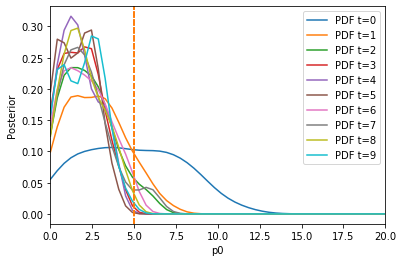

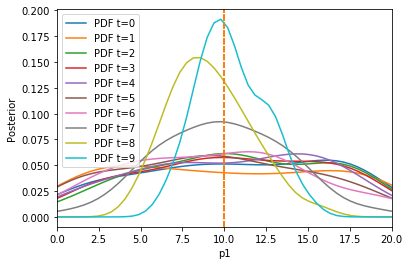

In [3]:
# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

Next, we account for the discrepancy in data point coutns by using factors:

INFO:History:Start <ABCSMC(id=42, start_time=2019-09-25 09:57:03.689500, end_time=None)>
INFO:Epsilon:initial epsilon is 12.80696365805519
INFO:ABC:t:0 eps:12.80696365805519
INFO:ABC:t:1 eps:9.014064851693654
INFO:ABC:t:2 eps:6.332961849188428
INFO:ABC:t:3 eps:4.072257301968437
INFO:ABC:t:4 eps:2.8389303117396185
INFO:ABC:t:5 eps:1.9246442669357013
INFO:ABC:t:6 eps:1.2816570900388362
INFO:ABC:t:7 eps:0.9598043607534473
INFO:ABC:t:8 eps:0.6904900404995975
INFO:ABC:t:9 eps:0.5093974211465332
INFO:History:Done <ABCSMC(id=42, start_time=2019-09-25 09:57:03.689500, end_time=2019-09-25 09:57:41.686558)>


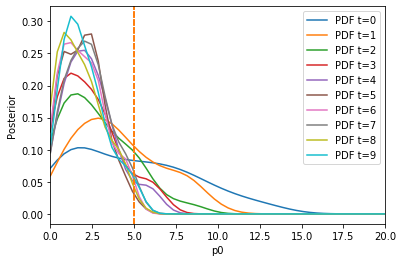

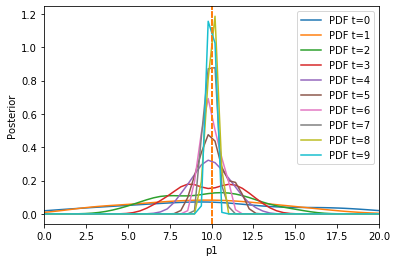

In [4]:
factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=10)

plot(history2)

Next, we consider automatic weighting and factors:

INFO:History:Start <ABCSMC(id=43, start_time=2019-09-25 09:57:42.715199, end_time=None)>
INFO:Epsilon:initial epsilon is 15.313858642301359
INFO:ABC:t:0 eps:15.313858642301359
INFO:ABC:t:1 eps:10.29121336626295
INFO:ABC:t:2 eps:7.014208632127261
INFO:ABC:t:3 eps:4.257329986396978
INFO:ABC:t:4 eps:3.2738962896805055
INFO:ABC:t:5 eps:2.5999440618784826
INFO:ABC:t:6 eps:2.0945004112401824
INFO:ABC:t:7 eps:1.653926394868312
INFO:ABC:t:8 eps:1.475849639440061
INFO:ABC:t:9 eps:1.5356652154621473
INFO:History:Done <ABCSMC(id=43, start_time=2019-09-25 09:57:42.715199, end_time=2019-09-25 09:58:18.267462)>


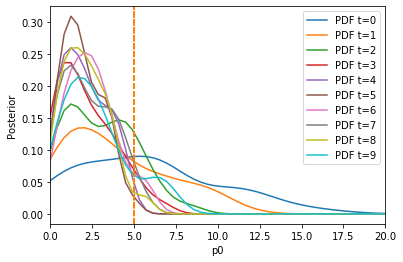

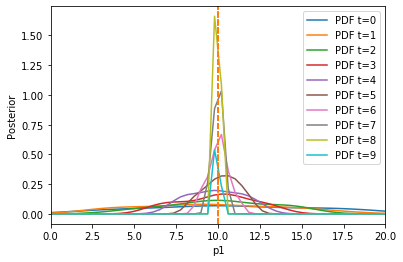

In [5]:
import logging
df_logger = logging.getLogger('Distance')
# df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=10)

plot(history3)

Next, we use adaptive distances but no factors:

INFO:History:Start <ABCSMC(id=44, start_time=2019-09-25 09:58:19.443686, end_time=None)>
INFO:Epsilon:initial epsilon is 744.2834211765459
INFO:ABC:t:0 eps:744.2834211765459
INFO:ABC:t:1 eps:372.39183967461383
INFO:ABC:t:2 eps:152.04530007129387
INFO:ABC:t:3 eps:73.00782199347844
INFO:ABC:t:4 eps:42.419555578680196
INFO:ABC:t:5 eps:19.012058159753657
INFO:ABC:t:6 eps:10.839328807933018
INFO:ABC:t:7 eps:7.169818188604591
INFO:ABC:t:8 eps:4.644385374993825
INFO:ABC:t:9 eps:2.9880964230318905
INFO:History:Done <ABCSMC(id=44, start_time=2019-09-25 09:58:19.443686, end_time=2019-09-25 09:59:49.495807)>


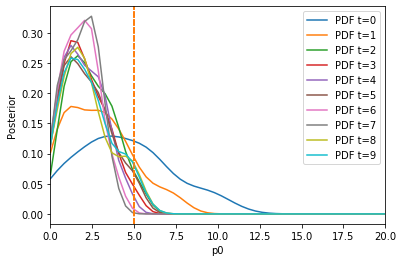

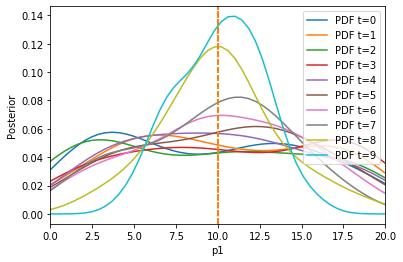

In [6]:
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=10)

plot(history4)

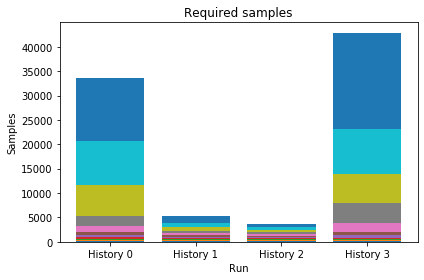

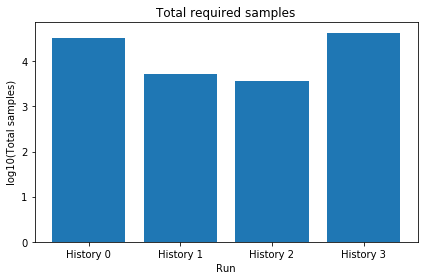

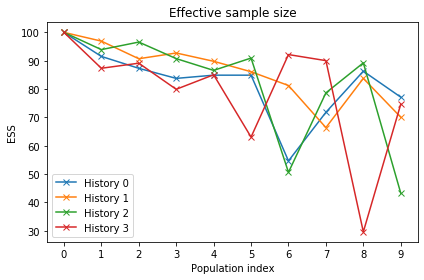

In [7]:
histories = [history1, history2, history3, history4]

pyabc.visualization.plot_sample_numbers(histories)
pyabc.visualization.plot_total_sample_numbers(histories, yscale='log10')
pyabc.visualization.plot_effective_sample_sizes(histories)

## Aggregating diverse distance functions

Now, we want to combine different distance metrics operating on subsets of the data to one distance value. We consider a slightly advanced model, combining a conversion reaction ODE model with samples from a normal distribution.

In [11]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

# true parameters
theta1_true, theta2_true = sp.exp([-2.5, -2])
theta_true = dict(theta1=theta1_true, theta2=theta2_true)

In [12]:
# conversion reaction (cr) model

measurement_data = sp.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])
measurement_times = sp.arange(len(measurement_data))      
init = sp.array([1, 0])


def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2


def cr_model(p):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(p["theta1"], p["theta2"]))
    return {"X_2": sol[:,1]}


def cr_l1_distance(simulation, data):
    return sp.absolute(data["X_2"] - simulation["X_2"]).sum()

In [13]:
# normal distribution samples


def gauss_model(p):
    samples = p['theta1'] + np.random.normal(size=100)
    return {'samples': samples}


def gauss_ks_distance(simulation, data):
    return stats.ks_2samp(simulation['samples'], data['samples']).statistic

observed_samples = gauss_model(theta_true)['samples']
# observation
observation = {'X_2': measurement_data,
               'samples': observed_samples}

The key is now to use `pyabc.distance.AggregatedDistance` to combine both.

In [14]:
def model(p):
    cr_ss = cr_model(p)
    gauss_ss = gauss_model(p)
    return {'X_2': cr_ss['X_2'], 'samples': gauss_model(p)['samples']}


distance = pyabc.distance.base.AggregatedDistance(
    distances=[cr_l1_distance, gauss_ks_distance], weights=[1, 10])
                           
# prior                           
parameter_prior = pyabc.Distribution(theta1=pyabc.RV("uniform", 0, 1),
                                     theta2=pyabc.RV("uniform", 0, 1))


abc = pyabc.ABCSMC(models=model,
                   parameter_priors=parameter_prior,
                   distance_function=distance,)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:History:Start <ABCSMC(id=46, start_time=2019-09-25 10:01:30.755153, end_time=None)>
INFO:Epsilon:initial epsilon is 5.091042913216227
INFO:ABC:t:0 eps:5.091042913216227
INFO:ABC:t:1 eps:2.704377616174995
INFO:ABC:t:2 eps:2.246834138748961
INFO:ABC:t:3 eps:1.920528631385973
INFO:ABC:t:4 eps:1.6628308057807455
INFO:History:Done <ABCSMC(id=46, start_time=2019-09-25 10:01:30.755153, end_time=2019-09-25 10:01:34.004877)>


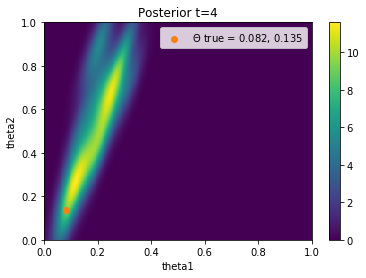

In [15]:
for t in range(h.max_t, h.max_t+1):
    ax = pyabc.visualization.plot_kde_2d(*h.get_distribution(m=0, t=t),
                                         "theta1", "theta2",
                xmin=0, xmax=1, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.scatter([theta1_true], [theta2_true],
                color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    theta1_true, theta2_true))
    ax.set_title("Posterior t={}".format(t))
    ax.legend()

In [16]:
for _ in range(10):
    p = dict(parameter_prior.rvs())
    sim = model(p)
    print(p, cr_l1_distance(sim, observation), gauss_ks_distance(sim, observation))
print(theta_true, gauss_ks_distance(observation, observation))

{'theta1': 0.8409140326101814, 'theta2': 0.3785360332726132} 4.217353284982552 0.3
{'theta1': 0.2987437300373458, 'theta2': 0.17560062971198964} 2.8800357422287224 0.08000000000000007
{'theta1': 0.7325192675286955, 'theta2': 0.7861663370490107} 2.298724872601459 0.33
{'theta1': 0.6103445344614367, 'theta2': 0.24172380145819472} 4.24102627705992 0.2
{'theta1': 0.12115818132062584, 'theta2': 0.6838580581538684} 1.054815803114755 0.10999999999999999
{'theta1': 0.9132919905895266, 'theta2': 0.3010582244264751} 4.8138418495826345 0.35
{'theta1': 0.9337694349225825, 'theta2': 0.6535582530510816} 3.3420515295626085 0.28
{'theta1': 0.7062242347265796, 'theta2': 0.2514858873893657} 4.525485445877599 0.29
{'theta1': 0.8682871294986532, 'theta2': 0.6413098738585329} 3.199205623833512 0.28
{'theta1': 0.2021056688383035, 'theta2': 0.896013899292917} 0.861950332736932 0.10000000000000003
{'theta1': 0.0820849986238988, 'theta2': 0.1353352832366127} 0.0
